In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random as rnd
from scipy.ndimage import convolve
from tqdm import tqdm

class DBM_RDG:

    def __init__(self,
                 N = 40,
                 dimensions=None,
                 nu=1.5,
                 debug=False,
                 threshold = 0.0001):

        # Unless specified, expect grid of NxNxN dimension, in order z, x, y
        if dimensions is None:
            self.dim = {'height': N, 'width': N,'depth': N}
        else:
            self.dim = {'height': dimensions[0], 'width': dimensions[1],'depth': dimensions[2]}

        # Create encoding grid and set all to 0
        #  0 encodes unfixed potential
        #  anything else encodes fixed potential
        # (I also use this grid to track order of cells in lightning structure)
        self.fixed_grid = np.zeros(shape=list(self.dim.values()))

        # Set all boundaries to be fixed
        self.fixed_grid[:, :, 0] = -1  # front boundary
        self.fixed_grid[:, :, -1] = -1  # back boundary
        self.fixed_grid[:, 0, :] = -1  # left boundary
        self.fixed_grid[:, -1, :] = -1  # right boundary
        self.fixed_grid[0, :, :] = -1  # top boundary
        self.fixed_grid[-1, :, :] = -1  # bottom boundary

        # The electric potential
        self.potential = np.zeros(shape=list(self.dim.values()))

        # The lightning downwards-tendency parameter
        self.nu = nu

        # Number of update steps
        self.steps = 1

        # To debug or not
        self.debug = debug

        # Keep track of current neighbors of structure
        self.structure_neighbors = set()

        self.struck_ground = False

        self.threshold = threshold

        # Debugging lists
        self.difference_per_conv = []
        self.overall_sum = []
        
        self.structure_history = []
        
        self.dist_to_ground = self.dim['height']

        # RDG Neighborhood
        self.neighbors = [(1, 0, 0), (0, 1, 0), (-1, 0, 0), (0,-1, 0), 
                          (0, -1, 1), (1, -1, 1), (0, 0, 1), (1, 0, 1),
                          (0, 1, -1), (-1, 1, -1), (0, 0, -1), (-1, 0, -1)]
        
        # Setup initial electric potential
        self.initial_electric_pot()

        # Add the first cell as a structure neighbor
        self.structure_neighbors.add((0, self.dim['width']//2, self.dim['depth']//2))
        # Update structure with that cell
        self.expand_lightning_to((0, self.dim['width']//2, self.dim['depth']//2))

        self.steps += 1
        
    def get_neighbors(self, pos):
        # Get the neighbors of a given position
        neighbors = []
        neighbors.append((pos[0], pos[1]+1, pos[2]  ))
        neighbors.append((pos[0], pos[1]  , pos[2]+1))
        neighbors.append((pos[0], pos[1]-1, pos[2]  ))
        neighbors.append((pos[0], pos[1]  , pos[2]-1))
        # Every other vertical layer has its 4 neighbors above and 4 below in a different orientation
        # This way, upwards is a jagged path that actually goes upwards, 
        # and not a diagonal path that tilts
        if pos[2] % 2 == 0:
            shift = -1
        else:
            shift = 1
        # 4 neighbors upwards (+1) and 4 downwards (-1)
        for direction in [+1, -1]:
            neighbors.append((pos[0]+direction, pos[1]      , pos[2]))
            neighbors.append((pos[0]+direction, pos[1]+shift, pos[2]))
            neighbors.append((pos[0]+direction, pos[1]      , pos[2]+shift))
            neighbors.append((pos[0]+direction, pos[1]+shift, pos[2]+shift))

        
        return neighbors


    def strike_lightning(self):

        # Run update until lightning strikes ground
        self.struck_ground = False

        # Create a tqdm tracker
        if self.debug or True:
            progress_bar = tqdm(total=self.dim['height'], desc="How close the lightning is to the ground", unit="iter")

        while not self.struck_ground:
            # Update lightning
            self.update()

            if self.debug or True:
                # If the newly added cell made the lightning stretch one step lower, update dist_to_ground
                if self.dim['height'] - self.newest_neighbor[0] < self.dist_to_ground:
                    self.dist_to_ground = self.dim['height'] - self.newest_neighbor[0]
                    progress_bar.update(1)

    def update(self):

        weights = []
        # For each structure neighbor
        for neighbor_pos in self.structure_neighbors:
            # Raise each weight to the power of nu
            weights.append(self.potential[neighbor_pos[0], neighbor_pos[1], neighbor_pos[2]] ** self.nu)
        
        # Choose a random neighbor with the weighting
        chosen_cell = rnd.choices(list(self.structure_neighbors), weights)[0]

        # Update lightning grid, potential and newest neighbor
        self.expand_lightning_to(chosen_cell)

        self.steps += 1

    def initial_electric_pot(self):

        # Create a linear gradient along the depth axis
        gradient = np.linspace(0, 1, self.dim['height'])[:, np.newaxis, np.newaxis]
        #gradient = np.linspace(0, 0, self.dim['height'])[:, np.newaxis, np.newaxis]

        # Apply the gradient to the array
        self.potential += gradient


    def expand_lightning_to(self, pos):
        '''
        Updates correpsonding grids
        Update neighborhood of lightning structure
        Call method to update electric potential
        '''

        self.newest_neighbor = pos
        
        self.structure_history.append(pos)

        # Remove the potential
        self.potential[pos[0], pos[1], pos[2]] = 0

        # Set it as a fixed cell
        self.fixed_grid[pos[0], pos[1], pos[2]] = self.steps

        # Update structure neighbors
        self.structure_neighbors.remove(pos)
        for neighbor_pos in self.get_neighbors(pos):
            if neighbor_pos[0] == self.dim['height']:
                self.struck_ground = True
                break

            if neighbor_pos[0] >= 0 and neighbor_pos[0] < self.dim['height'] and \
                neighbor_pos[1] >= 0 and neighbor_pos[1] < self.dim['width'] and \
                neighbor_pos[2] >= 0 and neighbor_pos[2] < self.dim['depth'] and \
                self.potential[neighbor_pos[0], neighbor_pos[1], neighbor_pos[2]] != 0:
                    self.structure_neighbors.add(neighbor_pos)

        if not self.struck_ground:
            # Update the rest of the potential
            self.potential = self.update_electric_potential()


    def update_electric_potential(self):
        '''
        Uses iterative diffusion to estimate solution to Laplace equation.
        Tracks percentual change for each cell after each diffusion, 
        terminates when the largest percentual change is less than threshold
        '''
        
        self.potential

        # Make ground and lightning structure fixed
        no_change_mask = self.fixed_grid != 0


        old_potential = np.copy(self.potential)
        new_potential = np.copy(old_potential)

        itr = 0
        # Until threshold
        while True:
            neighbor_avgs = np.zeros_like(new_potential)
            
            for x_pos in range(len(neighbor_avgs)):
                for y_pos in range(len(neighbor_avgs[0])):
                    for z_pos in range(len(neighbor_avgs[0][0])):
                        for neighbor_pos in self.get_neighbors((z_pos, x_pos, y_pos)):
                            if neighbor_pos[0] >= 0 and neighbor_pos[0] < self.dim['height'] and \
                               neighbor_pos[1] >= 0 and neighbor_pos[1] < self.dim['width'] and \
                               neighbor_pos[2] >= 0 and neighbor_pos[2] < self.dim['depth']:
                                neighbor_avgs[neighbor_pos[0], neighbor_pos[1], neighbor_pos[2]] += new_potential[x_pos, y_pos, z_pos] / len(self.neighbors)
                        
            #for dim in range(3):
            #    neighbor_avgs += np.roll(new_potential, shift=1, axis=dim)
            #    neighbor_avgs += np.roll(new_potential, shift=-1, axis=dim)
            #neighbor_avgs /= 6  # Divided by the number of neighbors  

            new_potential = neighbor_avgs

            # Reset the cells that shouldn't change
            new_potential[no_change_mask] = self.potential[no_change_mask]

            if self.debug:
                self.difference_per_conv.append(np.sum(abs(np.array(new_potential) - np.array(old_potential))))
                self.overall_sum.append(np.sum(np.array(new_potential)))
            
            # percentual change relative to previous iteration
            rel_differences = abs(np.array(new_potential) - np.array(old_potential))/np.array(old_potential)

            # Terminate when max percentual change is small (below threshold)
            if np.nanmax(rel_differences) < self.threshold:
                break

            old_potential = np.copy(new_potential)
            
        return new_potential

In [2]:
RDG_instance = DBM_RDG(dimensions=[20, 20, 20], nu=7, threshold=0.005)
RDG_instance.strike_lightning()
print(RDG_instance.structure_history)

C:\Users\gabri\AppData\Local\Temp/ipykernel_15904/635137158.py:229: RuntimeWarning: invalid value encountered in divide
  rel_differences = abs(np.array(new_potential) - np.array(old_potential))/np.array(old_potential)
How close the lightning is to the ground:  95%|████████████████████████████████████  | 19/20 [01:38<00:05,  5.17s/iter]

[(0, 10, 10), (1, 10, 10), (1, 9, 9), (1, 10, 9), (1, 11, 9), (1, 11, 10), (1, 9, 10), (1, 11, 11), (2, 12, 11), (3, 12, 12), (1, 13, 12), (4, 12, 11), (5, 13, 12), (6, 12, 12), (6, 12, 13), (7, 13, 13), (7, 13, 14), (7, 13, 12), (8, 14, 13), (8, 14, 12), (4, 11, 11), (1, 10, 11), (9, 14, 12), (8, 15, 13), (8, 14, 11), (7, 16, 13), (6, 17, 14), (7, 17, 13), (6, 17, 15), (8, 18, 13), (9, 18, 13), (5, 18, 15), (4, 18, 15), (7, 18, 16), (8, 17, 16), (6, 18, 14), (7, 18, 13), (8, 18, 14), (7, 16, 16), (5, 18, 16), (9, 16, 13), (4, 17, 16), (5, 18, 14), (8, 17, 17), (10, 18, 13), (9, 18, 17), (8, 18, 15), (7, 17, 18), (10, 18, 14), (8, 18, 17), (9, 18, 18), (5, 18, 17), (4, 18, 18), (7, 18, 14), (5, 17, 18), (6, 17, 18), (5, 18, 18), (8, 18, 18), (6, 18, 13), (10, 18, 18), (8, 15, 15), (11, 18, 18), (11, 18, 17), (12, 18, 17), (3, 18, 16), (9, 18, 14), (7, 18, 18), (12, 18, 18), (7, 18, 12), (2, 18, 16), (13, 18, 17), (6, 18, 18), (2, 17, 16), (12, 17, 17), (12, 18, 16), (13, 18, 16), (11, 

<IPython.core.display.Javascript object>


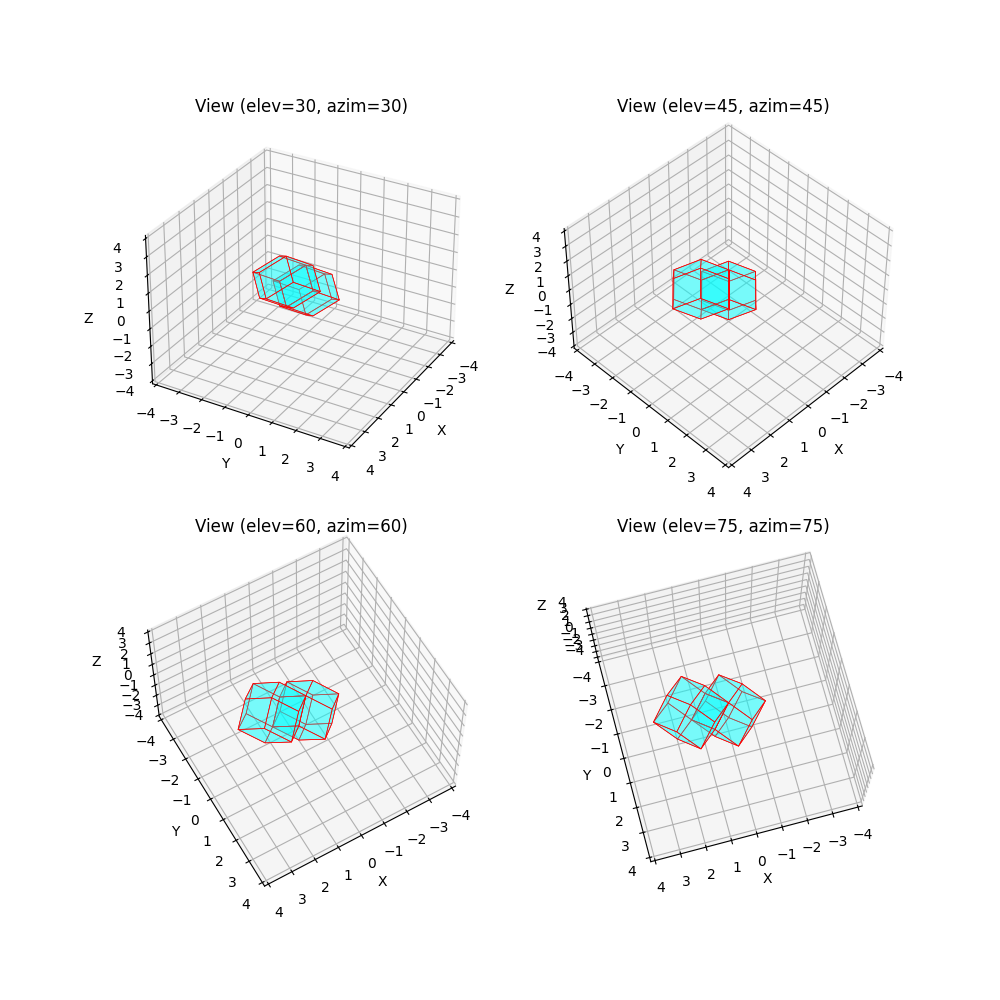

In [3]:
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
import copy

def rhombic_dodecahedron_vertices():
    """Return the vertices of a rhombic dodecahedron centered at the origin."""
    vertices = np.array([
        [ 1,  1,  1], # 0
        [ 1,  1, -1], # 1
        [ 1, -1,  1], # 2
        [ 1, -1, -1], # 3
        [-1,  1,  1], # 4
        [-1,  1, -1], # 5
        [-1, -1,  1], # 6
        [-1, -1, -1], # 7
        [ 0,  0,  2], # 8
        [ 0,  0, -2], # 9
        [ 0,  2,  0], # 10
        [ 0, -2,  0], # 11
        [ 2,  0,  0], # 12
        [-2,  0,  0]  # 13
    ])
    return vertices / np.sqrt(2)

def rhombic_dodecahedron_faces():
    """Return the faces of a rhombic dodecahedron using vertex indices."""
    faces = [
        [0, 8, 2, 12], [6, 8, 4, 13], [0, 8, 4, 10], [2, 8, 6, 11], # top 4
        [0, 10, 1, 12], [2, 12, 3, 11], [6, 11, 7, 13], [4, 13, 5, 10], # middle 4
        [1, 9, 3, 12], [7, 9, 5, 13], [1, 9, 5, 10], [3, 9, 7, 11] # bottom 4
    ]
    return faces

def plot_rhombic_dodecahedron(ax, pos=(0,0,0), color='cyan', alpha=0.3, scale=1, line_thickness = 1):
    vertices = rhombic_dodecahedron_vertices()
    faces = rhombic_dodecahedron_faces()

    pos = np.array(pos)

    cartes_pos = copy.deepcopy(pos)
    cartes_pos[0] += pos[1]# - 1*pos[2]//2

    cartes_pos[1] -= pos[0]# + 1*(pos[2]//2)

    #if pos[2] % 2 == 1:
    cartes_pos[0] += pos[2]
        #color = 'orange'

    poly3d = [[(np.array(vertices[vertice])+np.array(cartes_pos)*np.sqrt(2))*scale for vertice in face] for face in faces]
    ax.add_collection3d(Poly3DCollection(poly3d, facecolors=color, linewidths=0.5*line_thickness, edgecolors='r', alpha=alpha))

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    ax.set_zlim([-4, 4])
    
    
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt


def plot_from_grid(pos_list, colors=[], alphas=[], scale=1, line_thickness=1):
    
    if len(colors) != len(pos_list):
        colors = ['orange'] * len(pos_list)
    if len(alphas) != len(pos_list):
        alphas = [0.1] * len(pos_list)
    
    x = np.linspace(0, 2 * np.pi)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    for i, pos in enumerate(pos_list):
        plot_rhombic_dodecahedron(ax, gridpos_to_plot_pos(pos), colors[i], alpha=alphas[i], scale=scale, line_thickness=line_thickness)

    #plt.axis('off')

    def update(tilt = 0.2, jaw=1.0):
        ax.view_init(elev=tilt*90, azim=jaw*90)
        fig.canvas.draw_idle()

    interact(update);

# Define the angles you want to view the plot from
angles = [(30, 30), (45, 45), (60, 60), (75, 75)]

# Create subplots for each angle
fig = plt.figure(figsize=(10, 10))
for i, angle in enumerate(angles):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    plot_rhombic_dodecahedron(ax)
    plot_rhombic_dodecahedron(ax,pos=(0,0,1))
    ax.view_init(elev=angle[0], azim=angle[1])
    ax.set_title(f'View (elev={angle[0]}, azim={angle[1]})')

plt.show()

<IPython.core.display.Javascript object>


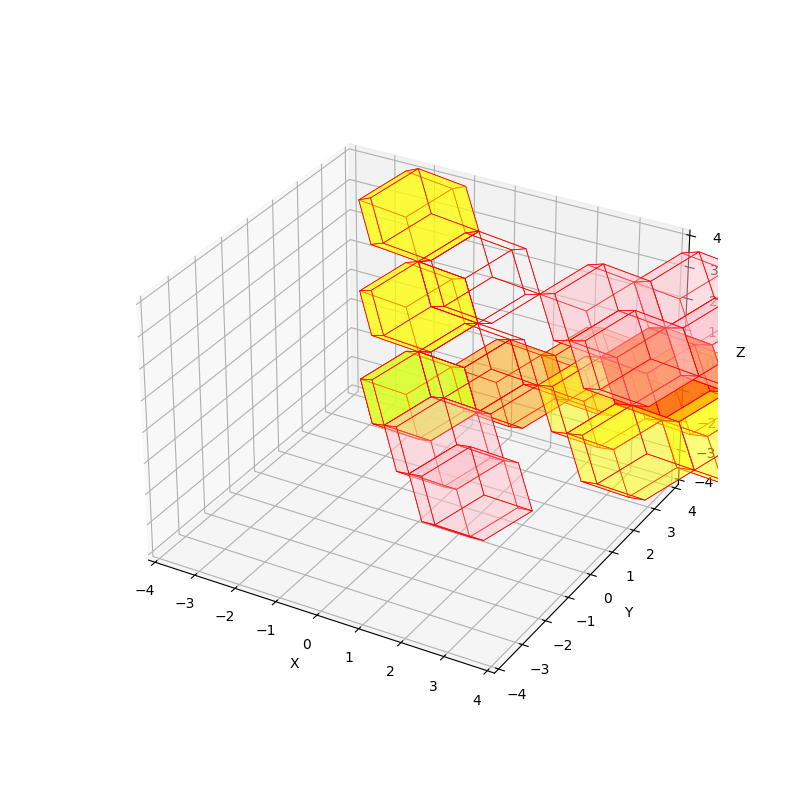

In [4]:
import numpy as np
grid = np.zeros((10,10,10))

def directly_up(pos):
    if pos[2] % 2 == 0:
        return (pos[0], pos[1], pos[2]+1)
    else:
        return (pos[0]-1, pos[1]-1, pos[2]+1)

def upwards_neighbors(pos):
    neighbors = []
    if pos[2] % 2 == 0:
        neighbors.append((pos[0], pos[1], pos[2]+1))
        neighbors.append((pos[0]-1, pos[1], pos[2]+1))
        neighbors.append((pos[0], pos[1]-1, pos[2]+1))
        neighbors.append((pos[0]-1, pos[1]-1, pos[2]+1))
    else:
        neighbors.append((pos[0], pos[1], pos[2]+1))
        neighbors.append((pos[0]+1, pos[1], pos[2]+1))
        neighbors.append((pos[0], pos[1]+1, pos[2]+1))
        neighbors.append((pos[0]+1, pos[1]+1, pos[2]+1))
    return neighbors

def below_neighbors(pos):
    neighbors = []
    if pos[2] % 2 == 0:
        neighbors.append((pos[0], pos[1], pos[2]-1))
        neighbors.append((pos[0]-1, pos[1], pos[2]-1))
        neighbors.append((pos[0], pos[1]-1, pos[2]-1))
        neighbors.append((pos[0]-1, pos[1]-1, pos[2]-1))
    else:
        neighbors.append((pos[0], pos[1], pos[2]-1))
        neighbors.append((pos[0]+1, pos[1], pos[2]-1))
        neighbors.append((pos[0], pos[1]+1, pos[2]-1))
        neighbors.append((pos[0]+1, pos[1]+1, pos[2]-1))
    return neighbors
        

def gridpos_to_plot_pos(pos):
    return (pos[0]-pos[2]//2, pos[1]-pos[2]//2, pos[2])


# Create subplots for each angle
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection='3d')


#plot_rhombic_dodecahedron(ax, pos=(0,0,1), color='green')
#plot_rhombic_dodecahedron(ax, pos=(0,0,-1), color='orange')
#plot_rhombic_dodecahedron(ax, pos=(1,0,0), color='yellow')
#plot_rhombic_dodecahedron(ax, pos=(-1,0,0), color='yellow')
plot_rhombic_dodecahedron(ax, pos=(0,2,0), color='orange')

plot_rhombic_dodecahedron(ax, pos=(0,1,0), color='orange')
#plot_rhombic_dodecahedron(ax, pos=(1,1,0), color='white')
#plot_rhombic_dodecahedron(ax, pos=(0,1,1), color='white')
#plot_rhombic_dodecahedron(ax, pos=(1,1,1), color='white')
plot_rhombic_dodecahedron(ax)

#plot_rhombic_dodecahedron(ax, pos=(0,-1,-1), color='yellow')
#plot_rhombic_dodecahedron(ax, pos=(-1,-1,0), color='yellow')
#plot_rhombic_dodecahedron(ax, pos=(0,-1,0), color='yellow')

#plot_rhombic_dodecahedron(ax, pos=(1,-2,0), color='white')
#plot_rhombic_dodecahedron(ax, pos=(0,-2,1), color='white')
#plot_rhombic_dodecahedron(ax, pos=(1,-2,1), color='white')


plot_rhombic_dodecahedron(ax, pos=(1,0,0), color='pink')
plot_rhombic_dodecahedron(ax, pos=(2,0,0), color='pink')

current_pos = (0,0,1)
for i in range(5):
    if i % 2 == 1:
        alpha = 0
    else:
        alpha = 0.5
    plot_rhombic_dodecahedron(ax, pos=gridpos_to_plot_pos((0,0,i)), color='yellow', alpha=alpha)
    #current_pos = directly_up(current_pos)
    #plot_rhombic_dodecahedron(ax, pos=current_pos, color='yellow')

#this_pos = (0,0,3)
#up_neighbors = upwards_neighbors(this_pos)
#for pos in up_neighbors:
    #plot_rhombic_dodecahedron(ax, pos=pos, color='pink')
    

#plot_rhombic_dodecahedron(ax, pos=(0,0,1), color='yellow')
#plot_rhombic_dodecahedron(ax, pos=(0,-1,1), color='yellow', alpha=0.05)
#plot_rhombic_dodecahedron(ax, pos=(-1,0,1), color='yellow', alpha=0.05)
#plot_rhombic_dodecahedron(ax, pos=(-1,-1,1), color='yellow', alpha=0.05)

#plot_rhombic_dodecahedron(ax, pos=(-1,-1,2), color='green')
#plot_rhombic_dodecahedron(ax, pos=(-1,-1,3))

center = (2,2,2)
plot_rhombic_dodecahedron(ax, pos=gridpos_to_plot_pos(center), color='yellow')
above = (2,2,2)
plot_rhombic_dodecahedron(ax, pos=gridpos_to_plot_pos(above), color='red')
#above = (2,3,2)
#plot_rhombic_dodecahedron(ax, pos=gridpos_to_plot_pos(above), color='pink')
#above = (3,2,2)
#plot_rhombic_dodecahedron(ax, pos=gridpos_to_plot_pos(above), color='pink')
#above = (3,3,2)
#plot_rhombic_dodecahedron(ax, pos=gridpos_to_plot_pos(above), color='pink')

up_neighbors = upwards_neighbors(center)
for pos in up_neighbors:
    plot_rhombic_dodecahedron(ax, pos=gridpos_to_plot_pos(pos), color='pink')
below_neighbors = below_neighbors(center)
for pos in below_neighbors:
    plot_rhombic_dodecahedron(ax, pos=gridpos_to_plot_pos(pos), color='yellow')


plt.show()

<IPython.core.display.Javascript object>


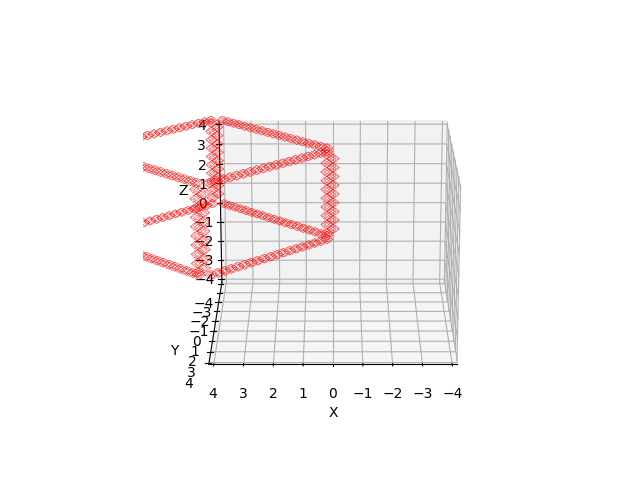

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

In [5]:
alphas = []
pos_list = []
# width, depth, height 
dims = (20, 20, 20)

# Plot the edges of the boundary
for x in range(1, dims[0]):
    pos_list.append((x, 0, 0)) 
    pos_list.append((x, dims[1], 0)) 
    pos_list.append((x, 0, dims[2]))
    pos_list.append((x, dims[1], dims[2]))
    for _ in range(4):
        alphas.append(0)
        
for y in range(1, dims[1]):
    pos_list.append((0, y, 0)) 
    pos_list.append((dims[0], y, 0)) 
    pos_list.append((0, y, dims[2]))
    pos_list.append((dims[0], y, dims[2]))
    for _ in range(4):
        alphas.append(0)
        
for z in range(1, dims[2]):
    pos_list.append((0, 0, z)) 
    pos_list.append((dims[0], 0, z)) 
    pos_list.append((0, dims[1], z))
    pos_list.append((dims[0], dims[1], z))
    for _ in range(4):
        alphas.append(0)


#plot the vertical target boundaries
#diff = 0
#for z in range(RDG_instance.dim['height'], -1, -1):
#    if z % 2 == 0:
#        diff += 1
#    pos_list.append((diff, diff, z))
#    alphas.append(1)

plot_from_grid(pos_list, alphas=alphas, scale=0.15, line_thickness=0.25)

<IPython.core.display.Javascript object>


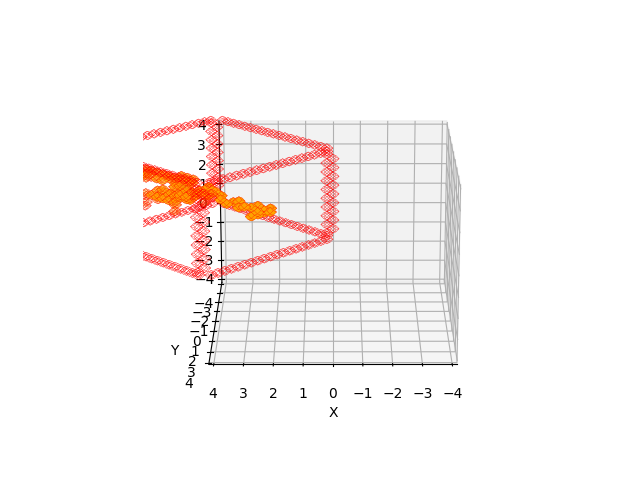

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

In [6]:
alphas = list(np.linspace(1, 0, len(RDG_instance.structure_history)))

pos_list = []
#pos_list.extend([(pos[1], pos[2], RDG_instance.dim['height']-pos[0]) for pos in RDG_instance.structure_history])
pos_list.extend(RDG_instance.structure_history)
#pos_list.extend([(i, 12, 12) for i in range(20)])



# Plot the edges of the boundary
for x in range(1, RDG_instance.dim['width']):
    pos_list.append((x, 0, 0)) 
    pos_list.append((x, RDG_instance.dim['depth'], 0)) 
    pos_list.append((x, 0, RDG_instance.dim['height']))
    pos_list.append((x, RDG_instance.dim['depth'], RDG_instance.dim['height']))
    for _ in range(4):
        alphas.append(0)
        
for y in range(1, RDG_instance.dim['depth']):
    pos_list.append((0, y, 0)) 
    pos_list.append((RDG_instance.dim['width'], y, 0)) 
    pos_list.append((0, y, RDG_instance.dim['height']))
    pos_list.append((RDG_instance.dim['width'], y, RDG_instance.dim['height']))
    for _ in range(4):
        alphas.append(0)
        
for z in range(1, RDG_instance.dim['height']):
    pos_list.append((0, 0, z))
    pos_list.append((RDG_instance.dim['width'], 0, z)) 
    pos_list.append((0, RDG_instance.dim['depth'], z))
    pos_list.append((RDG_instance.dim['width'], RDG_instance.dim['depth'], z))
    for _ in range(4):
        alphas.append(0)
        
#plot the vertical target boundaries
#diff = 0
#for z in range(RDG_instance.dim['height'], -1, -1):
#    if z % 2 == 0:
#        diff += 1
#    pos_list.append((diff, diff, z))
#    alphas.append(1)

plot_from_grid(pos_list, alphas=alphas, scale=0.15, line_thickness=0.25)

C:\Users\gabri\AppData\Local\Temp/ipykernel_15904/635137158.py:229: RuntimeWarning: invalid value encountered in divide
  rel_differences = abs(np.array(new_potential) - np.array(old_potential))/np.array(old_potential)


<IPython.core.display.Javascript object>


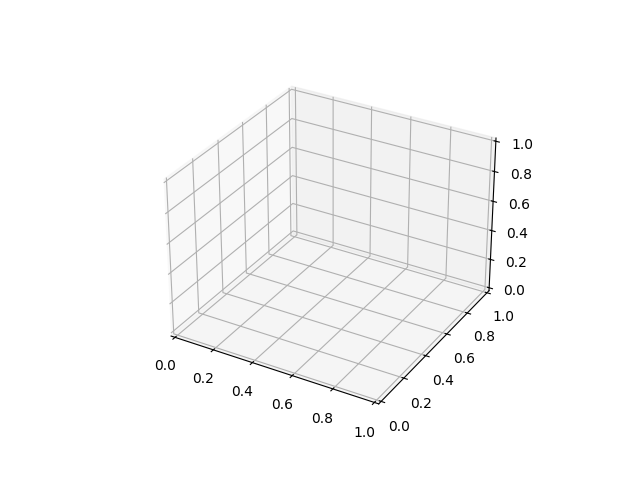

ValueError: 'rgb(255, 1, 1)' is not a valid color value.

In [7]:
RDG_instance_pot = DBM_RDG(dimensions=[20, 20, 20], nu=7, threshold=0.005)

fixed_z = 10

pos_list = []
alphas = []
fixed_alpha = 0.3
colors = []


for x in range(RDG_instance.dim['width']):
    for y in range(RDG_instance.dim['depth']):
        pos_list.append((x, y, fixed_z))
        alphas.append(fixed_alpha)
        pot = RDG_instance_pot.potential[x, y, fixed_z]
        colors.append(f'rgb(255, {int(200*pot+1)}, {int(200*pot+1)})')

plot_from_grid(pos_list, alphas=alphas, colors=colors, scale=0.15, line_thickness=0.25)

<IPython.core.display.Javascript object>


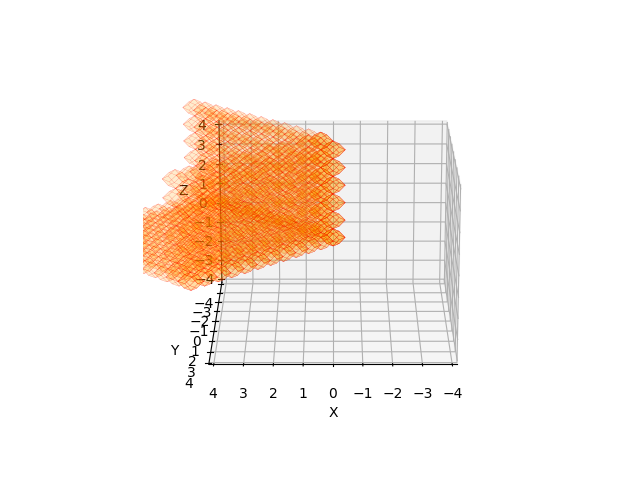

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

In [8]:
alphas = list(np.linspace(1, 0, len(RDG_instance.structure_history)))

pos_list = []
pos_list.extend([(0,0,i) for i in range(12)])
for x in range(12):
    for y in range(12):
        pos_list.append((x, y, 0)) 
        pos_list.append((x, 0, y)) 
        pos_list.append((0, x, y))
        alphas.append(0)
        alphas.append(0)
        alphas.append(0)

plot_from_grid(pos_list, alphas=alphas, scale=0.3, line_thickness=0.1)

<IPython.core.display.Javascript object>


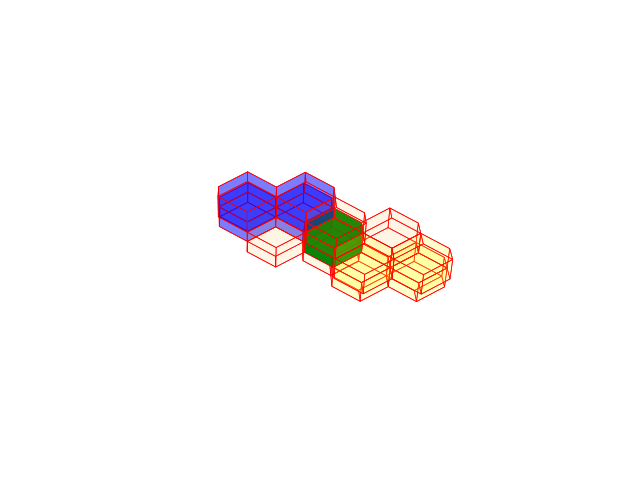

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

In [9]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt


def plot_from_grid(pos_list, colors, alphas):
    x = np.linspace(0, 2 * np.pi)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    for i, pos in enumerate(pos_list):
        plot_rhombic_dodecahedron(ax, pos, colors[i], alpha=alphas[i])

    plt.axis('off')

    def update(tilt = 0.2, jaw=1.0):
        ax.view_init(elev=tilt*90, azim=jaw*90)
        fig.canvas.draw_idle()

    interact(update);


pos_list = []
for i in range(5):
    pos_list.append((0,0,i))

for i in range(5):
    pos_list.append((0,i,4))

for i in range(5):
    pos_list.append((i,4,4))

#plot_from_grid(pos_list)

center = (0,0,0)
pos_list = []
colors = []
alphas = []
pos_list.append(center)
colors.append('green')
alphas.append(0.8)
for i, neighbor in enumerate([(1, 0, 0), (0, 1, 0), (-1, 0, 0), (0,-1, 0), 
                          (0, -1, 1), (1, -1, 1), (0, 0, 1), (1, 0, 1),
                          (0, 1, -1), (-1, 1, -1), (0, 0, -1), (-1, 0, -1)]):

    pos_list.append((center[0]+neighbor[0],center[1]+neighbor[1],center[2]+neighbor[2]))
    if i > 3 and i < 8:
        colors.append('blue')
        alphas.append(0.3)
    elif i >= 8:
        colors.append('yellow')
        alphas.append(0.1)
    else:
        colors.append('orange')
        alphas.append(0.05)
#pos_list.append((1,0,0))
#pos_list.append((0,1,0))
#pos_list.append((-1,0,0))
#pos_list.append((0,-1,0))
plot_from_grid(pos_list, colors, alphas)


[(0, 0, -2), (0, 0, -1), (0, 0, 0), (0, 0, 1), (0, -1, 2)]
[(0, 0, -2), (0, 0, -1), (0, 0, 0), (0, 0, 1), (0, -1, 2), (1, -1, 2)]
[(0, 0, -2), (0, 0, -1), (0, 0, 0), (0, 0, 1), (0, -1, 2), (1, -1, 2), (0, 0, 2)]
[(0, 0, -2), (0, 0, -1), (0, 0, 0), (0, 0, 1), (0, -1, 2), (1, -1, 2), (0, 0, 2), (1, 0, 2)]


<IPython.core.display.Javascript object>


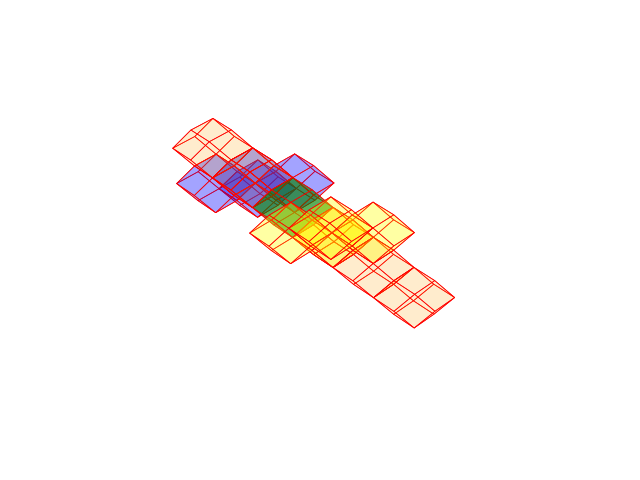

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

In [10]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt


def plot_from_grid(pos_list, colors, alphas):
    x = np.linspace(0, 2 * np.pi)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    for i, pos in enumerate(pos_list):
        plot_rhombic_dodecahedron(ax, pos, colors[i], alpha=alphas[i])

    plt.axis('off')

    def update(tilt = 0.2, jaw=1.0):
        ax.view_init(elev=tilt*90, azim=jaw*90)
        fig.canvas.draw_idle()

    interact(update);


pos_list = []
for i in range(5):
    pos_list.append((0,0,i))

for i in range(5):
    pos_list.append((0,i,4))

for i in range(5):
    pos_list.append((i,4,4))

#plot_from_grid(pos_list)

center = (0,0,-3)
pos_list = []
colors = []
alphas = []
for i in range(-2,4):

    pos_list.append((0,0,i))
    if i == 1:
        colors.append('green')
        alphas.append(0.4)
        
        for above_neigh in [(0, -1, 1), (1, -1, 1), (0, 0, 1), (1, 0, 1)]:
            pos_list.append((above_neigh[0],above_neigh[1],above_neigh[2]+i))
            print(pos_list)
            colors.append('blue')
            alphas.append(0.2)
            
        for below_neigh in [(0, 1, -1), (-1, 1, -1), (0, 0, -1), (-1, 0, -1)]:
            pos_list.append((below_neigh[0],below_neigh[1],below_neigh[2]+i))
            colors.append('yellow')
            alphas.append(0.2)
    else:
        colors.append('orange')
        alphas.append(0.1)
        
#pos_list.append((1,0,0))
#pos_list.append((0,1,0))
#pos_list.append((-1,0,0))
#pos_list.append((0,-1,0))
plot_from_grid(pos_list, colors, alphas)


<IPython.core.display.Javascript object>


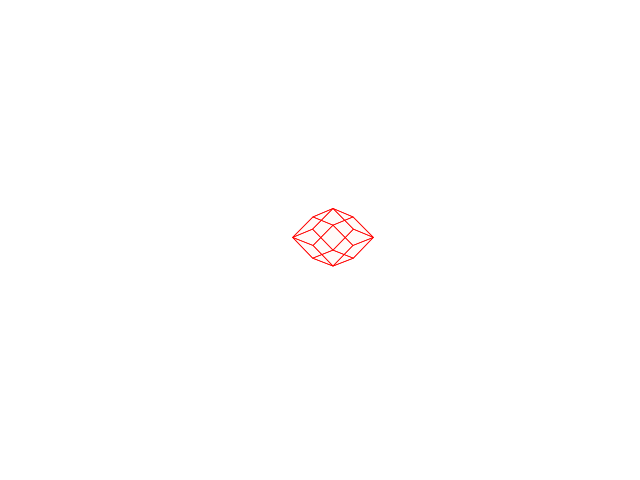

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

<IPython.core.display.Javascript object>


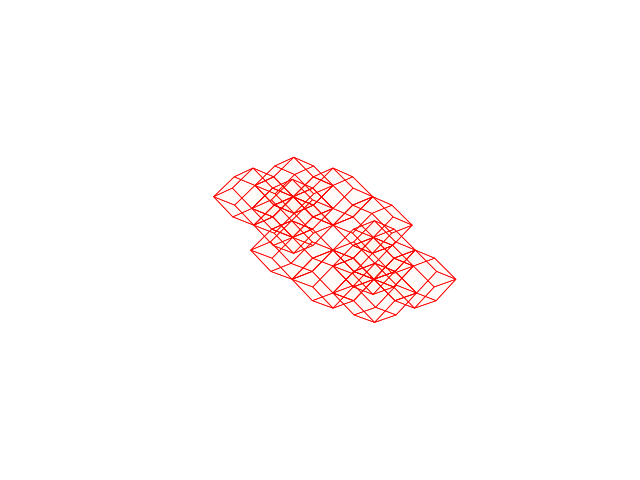

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

<IPython.core.display.Javascript object>


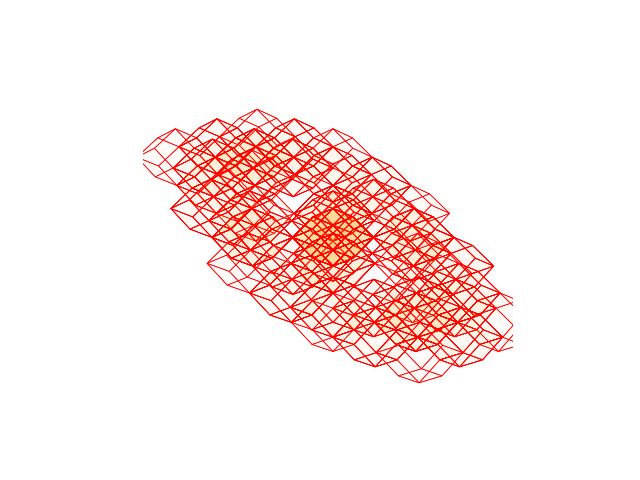

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

<IPython.core.display.Javascript object>


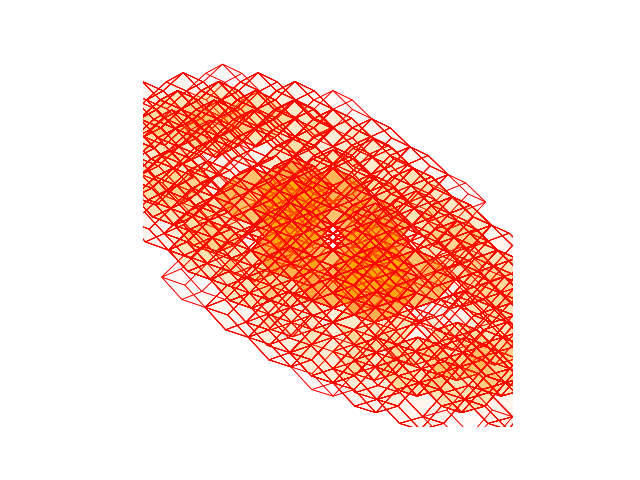

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

<IPython.core.display.Javascript object>


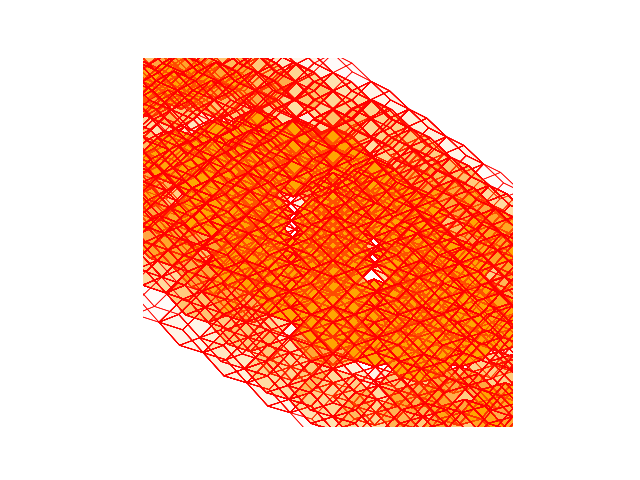

interactive(children=(FloatSlider(value=0.2, description='tilt', max=0.6000000000000001, min=-0.2), FloatSlide…

In [11]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt


def plot_from_grid(pos_list, colors, alphas):
    x = np.linspace(0, 2 * np.pi)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    for i, pos in enumerate(pos_list):
        plot_rhombic_dodecahedron(ax, pos, colors[i], alpha=alphas[i])

    plt.axis('off')

    def update(tilt = 0.2, jaw=1.0):
        ax.view_init(elev=tilt*90, azim=jaw*90)
        fig.canvas.draw_idle()

    interact(update);


neighbors = [(1, 0, 0), (0, 1, 0), (-1, 0, 0), (0,-1, 0), 
            (0, -1, 1), (1, -1, 1), (0, 0, 1), (1, 0, 1),
            (0, 1, -1), (-1, 1, -1), (0, 0, -1), (-1, 0, -1)]

center = (0,0,0)
pos_list = [center]
colors = ['orange']
alphas = [0.01]
plot_from_grid(pos_list, colors, alphas)

for _ in range(4):
    colors = []
    alphas = []
    old_pos_list = []
    old_pos_list.extend(pos_list[:])
    pos_list = []
    for pos in old_pos_list:
        for neighbor in neighbors:
            if (neighbor[0]+pos[0], neighbor[1]+pos[1], neighbor[2]+pos[2]) not in old_pos_list:
                pos_list.append((neighbor[0]+pos[0], neighbor[1]+pos[1], neighbor[2]+pos[2]))
                colors.append('orange')
                alphas.append(0.01)
    plot_from_grid(pos_list, colors, alphas)
